In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [39]:
logs = pd.read_csv("logs_textos_usuario.csv")

# Iniciamos la limpiesa del DataSet original

In [63]:
print("Existen ",len(logs.intent.unique()), " tipos distintos de respuestas para intent")
print(logs.shape[1]," columnas en logs_textos_usuario.csv")

Existen  140  tipos distintos de respuestas para intent
12  columnas en logs_textos_usuario.csv


In [58]:
logs.resolved.unique()

array(['NO', nan, 'SI'], dtype=object)

### Tenemos valores nulos en resolved, los cuales debemos extraer de nuestro DataSet por no generar informacion en un modelo de prediccion.

In [66]:
mask=logs.resolved.isna()
logs_nonan=logs[~mask]
print("Hay", logs.shape[0]-logs_nonan.shape[0], "valores nulos en el DataSet logs_textos_usuario.csv")
print("Quedamos con un DataSet final de :", logs_nonan.shape[0]," lineas")

Hay 34445 valores nulos en el DataSet logs_textos_usuario.csv
Quedamos con un DataSet final de : 20069  lineas


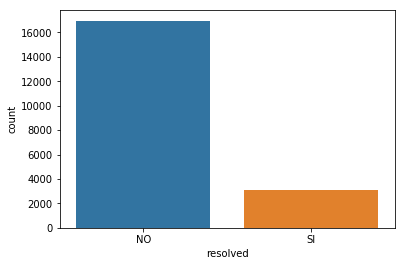

In [74]:
logs_nonan1 = logs_nonan.drop(['conversationId','createAt'], axis=1) 
sns.countplot(logs_nonan1["resolved"])

In [75]:
logs_nonan1.groupby(by="resolved").count()

,text,intent,intentScore,selectedOption,topIntent1,topIntent2,topIntent3,topIntent4,topIntent5
resolved,,,,,,,,,
NO,16958,16956,16956,16958,16958,16958,16958,16958,16958
SI,3111,3111,3111,0,0,0,0,0,0


### La tasa de resueltos por en el DataSet no es muy acertada, por lo que separamos en dos DataFrame, uno para los Resueltos y otros para los no Resuelto, para luego crear un DataSet final solo con el texto ingresado por el cliente y los intent o respuestas finales dadas por el bot que creo el DataSet logs_textos_usuario.csv

In [76]:
resolved1 = logs_nonan1[logs_nonan1['resolved']=='SI']
not_resolved = logs_nonan1[logs_nonan1['resolved']=='NO']

### Para el DatSet not_resolved hacemos mach de la seleccion con el topIntent que corresponda y creamos una nueva columna con el nombre intent2.
    selectedOption 1: topIntent1
    selectedOption 2: topIntent2
    selectedOption 3: topIntent3
    selectedOption 4: topIntent4
    selectedOption 5: topIntent5

In [77]:
not_resolved.selectedOption = not_resolved.selectedOption.astype('int') #selectedOption actualmente esta como float

In [78]:
def get_final_option(row):
    select=not_resolved.columns[row.selectedOption+4]
    return row[select]

In [79]:
not_resolved["intent2"]=not_resolved.apply(get_final_option,axis=1)
not_resolved2 = not_resolved.drop(['topIntent1','topIntent2',"topIntent3","topIntent4","topIntent5","resolved","selectedOption","intentScore","intent"], axis=1) 

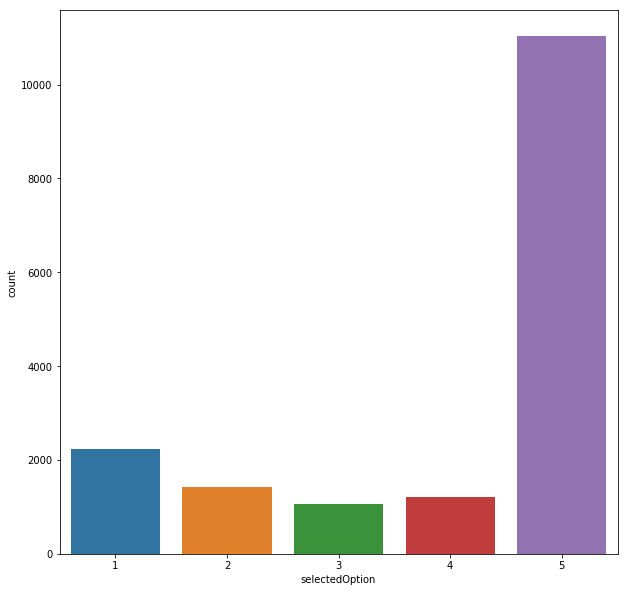

In [80]:
fig, ax =  plt.subplots(figsize=(10,10))
sns.countplot(not_resolved["selectedOption"],ax=ax)

### En este grafico se aprecia la desproporcion de seleccion de la opcion 5: Ninguna.
### La cual debemos extraer del DataSet que usaremos para crear el modelo de prediccion.

In [83]:
not_resolved2=not_resolved2.rename(columns={'intent2': 'intent'})
mask=not_resolved2['intent']=='Ninguna'
resolved_no = not_resolved2[~mask]
resolved_ninguna = not_resolved2[mask]

In [84]:
resolved_si=resolved1.drop(['topIntent1','topIntent2',"topIntent3","topIntent4","topIntent5","resolved","selectedOption","intentScore"], axis=1) 
resolved_si.head()

,text,intent
3,Me cortaron el servicio por un monto no pagado...,HANDOVER_RECLAMOS
12,Hola buenas tardes quiero saber donde puedo ba...,KGB_INSTAMCAFEEBANDAANCHA
21,Cómo puedo terminar mi contrato móvil,HANDOVER_BAJA
43,Y quiero pedir una prórroga,KGB_PRORROGA
62,me gustaria rebajar mi plan de telefonia mobil...,KGB_SOLCAMBIPLAN


In [85]:
resolved_ok=pd.concat([resolved_si, resolved_no])
mask=resolved_ok.intent=="None"
resolved_ok = resolved_ok[~mask].reset_index(drop=True)
resolved_ok.head(5)

,text,intent
0,Me cortaron el servicio por un monto no pagado...,HANDOVER_RECLAMOS
1,Hola buenas tardes quiero saber donde puedo ba...,KGB_INSTAMCAFEEBANDAANCHA
2,Cómo puedo terminar mi contrato móvil,HANDOVER_BAJA
3,Y quiero pedir una prórroga,KGB_PRORROGA
4,me gustaria rebajar mi plan de telefonia mobil...,KGB_SOLCAMBIPLAN


In [88]:
print("En tal hay ",len(resolved_ok.intent.unique()),"opciones validas para la prediccion.")

En tal hay  126 opciones validas para la prediccion.


In [89]:
resolved_ok.to_csv("resolved_ok.csv",index=False)
resolved_ninguna.to_csv("resolved_ninguna.csv",index=False)